In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pathlib

In [5]:
import numpy as np
import pandas as pd
import xarray as xr

In [6]:
import sys

In [7]:
sys.path.append('/home/nicolasf/research/Smart_Ideas/code/ml4seas/')

In [8]:
from GCM import regrid
from GCM import (fix_grid, preprocess_ECMWF_nc)
from utils import (list_files, save_by_month)

xesmf is not installed, using method `interp_like` for interpolation


In [9]:
provider = 'CDS'

In [10]:
GCM = 'ECMWF'

In [11]:
varname = 'SST'

In [12]:
save_clim = True

### path where the files have been downloaded 

In [13]:
dpath = f'/media/nicolasf/END19101/data/GCMs/downloads/{GCM}/{varname}'

In [14]:
dpath = pathlib.Path(dpath)

### list the files 

In [15]:
lfiles = list_files(dpath, pattern=f"*{GCM}*", extension=".nc", verbose=1)

loaded files, list length 468
the first file is /media/nicolasf/END19101/data/GCMs/downloads/ECMWF/SST/CDS_ECMWF_SST_1981_01.nc
the last file is /media/nicolasf/END19101/data/GCMs/downloads/ECMWF/SST/CDS_ECMWF_SST_2019_12.nc


In [16]:
dset = xr.open_dataset(lfiles[0])

In [17]:
dset

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, number: 25, time: 6)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 1981-06-01
Data variables:
    sst        (time, number, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-15 02:35:29 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [18]:
dset_all = xr.open_mfdataset(lfiles, concat_dim='init_time', preprocess=preprocess_ECMWF_nc, parallel=True)

In [ ]:
dset_all

In [19]:
if varname == 'PRECIP': 
    dset_all = convert_rainfall(dset_all, time_var='init_time')
if varname == 'SST': 
    mask = dset_all['sst'].isel(init_time=0, step=0, member=0)
    mask = mask.where(np.isnan(mask), 1)
    mask = mask.drop(['member','step','init_time'])
    dset_all['mask'] = mask 
    dset_all['sst'] = dset_all['sst'] * dset_all['mask']
    dset_all = dset_all.drop('mask') 

### calculates the climatology 

In [20]:
clim_years = ['1981', '2010']
# clim_years = ['1993','2016']

In [21]:
clim = dset_all.sel(init_time=slice(*clim_years)).mean('member')

In [22]:
clim = clim.groupby(clim.init_time.dt.month).mean()

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


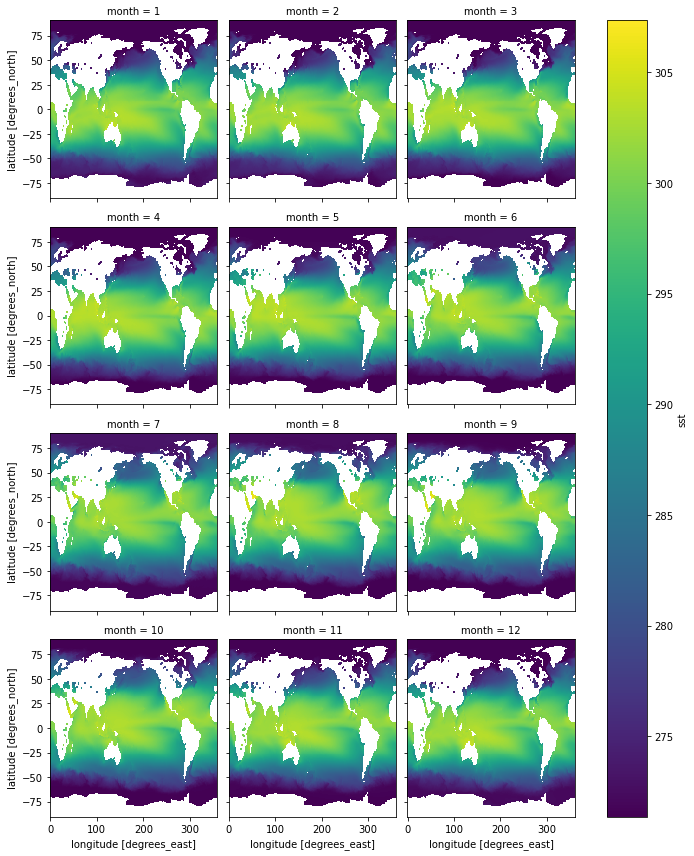

In [23]:
fg = clim.isel(step=0)['sst'].plot(x='lon',y='lat', col='month', col_wrap=3) 

In [24]:
if varname == 'PRECIP': 
    clim = clim.drop('ndays')

In [25]:
opath = dpath.parents[2].joinpath(f'processed/{provider}/{GCM}/{varname}')

print(str(opath))

if not opath.exists():
    opath.mkdir(parents=True)

clim_path = opath.joinpath('CLIMATOLOGY')

if not clim_path.exists():
    clim_path.mkdir(parents=True)

/media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/SST


In [26]:
clim_path

PosixPath('/media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/SST/CLIMATOLOGY')

### saves the climatology to disk 

In [27]:
if save_clim: 
    for m in clim.month.data: 
        c = clim.sel(month=m) 
        fname_out = f"CDS_ECMWF_{varname}_monthly_{'_'.join(clim_years)}_clim_{str(m).zfill(2)}.nc"
        c.to_netcdf(clim_path.joinpath(fname_out))
        c.close()

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.p

### calculates the monthly anomalies 

In [28]:
anoms = (dset_all.groupby(dset_all.init_time.dt.month)) - clim

In [29]:
anoms

,Array,Chunk
Bytes,18.30 GB,39.10 MB
Shape,"(468, 6, 25, 181, 360)","(1, 6, 25, 181, 360)"
Count,7180 Tasks,468 Chunks
Type,float32,numpy.ndarray


### plots some anomalies to check if they make sense 

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


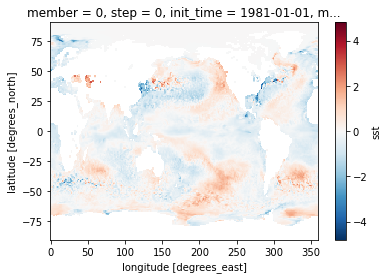

In [30]:
anoms['sst'][0,0,0,:,:].plot()

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


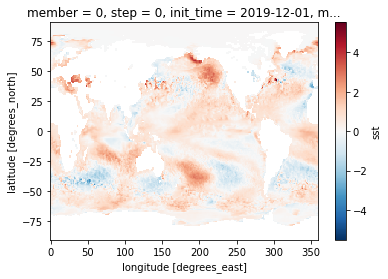

In [31]:
anoms['sst'][-1,0,0,:,:].plot()

### plots the ENSO 1997 - 1998

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


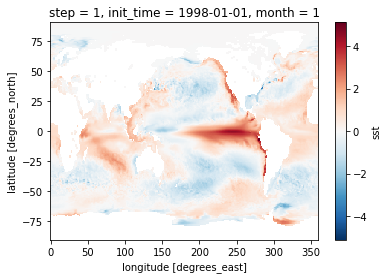

In [32]:
anoms.sel(init_time='1998-01-01')['sst'].mean('member').isel(step=1).plot()

### opens the target grid for interpolation 

In [33]:
anoms

,Array,Chunk
Bytes,18.30 GB,39.10 MB
Shape,"(468, 6, 25, 181, 360)","(1, 6, 25, 181, 360)"
Count,7180 Tasks,468 Chunks
Type,float32,numpy.ndarray


In [34]:
out_grid = xr.open_dataset('/media/nicolasf/END19101/data/GCMs/target_grid/target_grid_2.5_2.5.nc')

### saves the monthly anomalies, non interpolated 

In [35]:
save_by_month(anoms, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"monthly_anomalies_{'_'.join(clim_years)}_clim", verbose=False)

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.p

### calculates the seasonal averages (of the anomalies )

In [43]:
anoms_seas = anoms.rolling(step=3, min_periods=3).mean()

In [44]:
for d in range(len(anoms_seas.init_time)): 
    sub = anoms_seas.isel(init_time=d)
    

,Array,Chunk
Bytes,18.30 GB,32.58 MB
Shape,"(468, 6, 25, 181, 360)","(1, 5, 25, 181, 360)"
Count,39943 Tasks,936 Chunks
Type,float32,numpy.ndarray


In [52]:
d = 0

In [53]:
sub = anoms_seas.isel(init_time=d)

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


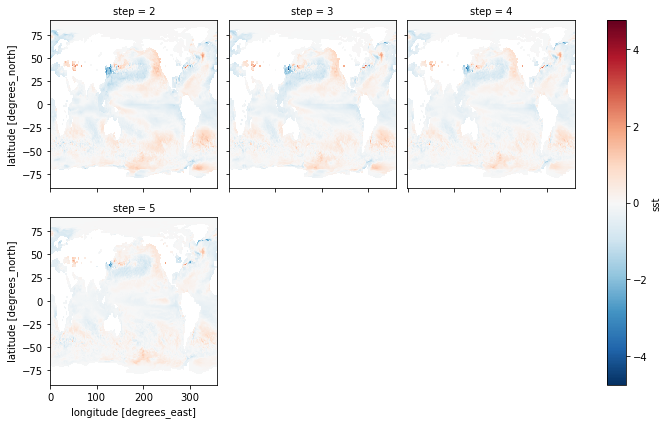

In [54]:
sub.mean('member')['sst'].plot(x='lon',y='lat', col='step', col_wrap=3)

In [51]:
anoms_seas = anoms_seas.isel(step=slice(2,None))

### saves the seasonal anomalies, non interpolated 

In [ ]:
save_by_month(anoms_seas, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"seasonal_anomalies_{'_'.join(clim_years)}_clim", verbose=True)

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1981-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1982-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1983-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1984-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1985-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1986-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1987-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1988-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1989-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1990-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1991-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1992-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1993-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1994-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1995-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1996-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1997-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1998-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_1999-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2000-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2001-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-02_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-03_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-04_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-05_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-06_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-07_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-08_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-09_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-10_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-11_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2002-12_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


successfully saved CDS_ECMWF_SST_2003-01_seasonal_anomalies_1981_2010_clim.nc


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Now interpolates onto the 2.5 x 2.5 grid and saves to file

In [ ]:
anoms_interp = anoms.interp_like(out_grid)

In [ ]:
save_by_month(anoms_interp, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"monthly_anomalies_interp_{'_'.join(clim_years)}_clim", verbose=False)

In [ ]:
anoms_seas_interp = anoms_seas.interp_like(out_grid)

In [ ]:
save_by_month(anoms_seas_interp, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"seasonal_anomalies_interp_{'_'.join(clim_years)}_clim", verbose=False)